In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator

from scipy import odr
from scipy.optimize import curve_fit, least_squares
from scipy.stats import norm

In [76]:
def complex_step_derivative(model_func, x, params, h=1e-20):
    """Compute df/dx using complex-step differentiation (numerically stable)."""
    x = np.asarray(x, dtype=np.complex128)
    return np.imag(model_func(params, x + 1j * h)) / h

def odr_fit(x, y, x_err, y_err, model_func, beta0):
    """
    Run ODR and report vertical goodness-of-fit metrics (R², chi², reduced chi², AICc, BIC).

    Parameters
    ----------
    x, y : array_like
        Data points
    model_func : callable
        Model function f(B, x)
    beta0 : array_like
        Initial guess for parameters
    x_err, y_err : array_like, optional
        Standard deviations (used for ODR weighting)

    Returns
    -------
    result : dict
        Dictionary containing:
        - beta : fitted parameters
        - beta_err : parameter uncertainties
        - y_fit : fitted y values (ODR projections)
        - metrics : dict with vertical R², chi², reduced chi², AICc, BIC
        - odr_output : raw ODR output object
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    k = len(beta0)

    if x_err is None:
        x_err = np.zeros_like(x)
    if y_err is None:
        y_err = np.ones_like(y)

    # Run ODR
    data = odr.RealData(x, y, sx=x_err, sy=y_err)
    model = odr.Model(model_func)
    odr_obj = odr.ODR(data, model, beta0=beta0)
    output = odr_obj.run()

    # Fitted values along orthogonal projection
    y_fit = output.y

    # Vertical residuals for metrics
    residuals = y - y_fit

    # Chi-square
    chi2 = np.sum((residuals / y_err) ** 2)
    chi2_red = chi2 / (n - k)

    # Weighted R² (vertical)
    weights = 1 / y_err**2
    y_mean_w = np.sum(weights * y) / np.sum(weights)
    ss_res = np.sum(weights * residuals**2)
    ss_tot = np.sum(weights * (y - y_mean_w)**2)
    R2_w = 1 - ss_res / ss_tot

    # === Full log-likelihood and information criteria ===
    y_model = output.y
    df_dx = complex_step_derivative(model_func, x, output.beta)
    sigma_eff2 = y_err**2 + (df_dx**2) * x_err**2
    sigma_eff2 = np.clip(sigma_eff2, 1e-300, np.inf)
    resid = y - y_model

    logL = -0.5 * np.sum((resid**2) / sigma_eff2 + np.log(2 * np.pi * sigma_eff2))
    AIC = 2 * k - 2 * logL
    AICc = np.inf
    if n - k - 1 > 0:
        AICc = AIC + (2 * k * (k + 1)) / (n - k - 1)
    BIC = k * np.log(n) - 2 * logL

    return {
        "beta": output.beta,
        "beta_err": output.sd_beta,
        "y_fit": y_fit,
        "R2_w": R2_w,
        "chi2": chi2,
        "chi2_red": chi2_red,
        "AICc": AICc,
        "BIC": BIC,
        "cov": output.cov_beta * output.res_var,
        "odr_output": output
    }

def wls_fit(x, y, y_err, model_func, beta0):
    """
    Perform a Weighted Least Squares fit and compute goodness-of-fit metrics.

    Parameters
    ----------
    x, y : array_like
        Data points
    model_func : callable
        Model function f(x, *params)
    beta0 : array_like
        Initial guess for parameters
    y_err : array_like
        Standard deviations in y (used for weighting)

    Returns
    -------
    dict
        - beta, beta_err
        - y_fit
        - metrics: weighted R², chi², reduced chi², logL, AIC, AICc, BIC
    """
    x = np.asarray(x)
    y = np.asarray(y)
    y_err = np.asarray(y_err)
    n = len(x)
    k = len(beta0)

    # Weighted least squares fit using curve_fit
    popt, pcov = curve_fit(model_func, x, y, p0=beta0, sigma=y_err, absolute_sigma=False)
    y_fit = model_func(popt, x)
    residuals = y - y_fit
    beta_err = np.sqrt(np.diag(pcov))

    # Weighted R²
    weights = 1 / y_err**2
    y_mean_w = np.sum(weights * y) / np.sum(weights)
    ss_res = np.sum(weights * residuals**2)
    ss_tot = np.sum(weights * (y - y_mean_w)**2)
    R2_wls = 1 - ss_res / ss_tot

    # Chi-square
    chi2 = np.sum((residuals / y_err)**2)
    chi2_red = chi2 / (n - k)

    # Full log-likelihood assuming Gaussian errors
    sigma2 = y_err**2
    sigma2 = np.clip(sigma2, 1e-300, np.inf)
    logL = -0.5 * np.sum((residuals**2)/sigma2 + np.log(2*np.pi*sigma2))

    # AIC, AICc, BIC
    AIC = 2 * k - 2 * logL
    AICc = np.inf
    if n - k - 1 > 0:
        AICc = AIC + (2 * k * (k + 1)) / (n - k - 1)
    BIC = k * np.log(n) - 2 * logL

    return {
        "beta": popt,
        "beta_err": beta_err,
        "y_fit": y_fit,
        "R2_wls": R2_wls,
        "chi2": chi2,
        "chi2_red": chi2_red,
        "logL": logL,
        "AIC": AIC,
        "AICc": AICc,
        "BIC": BIC,
        "cov": pcov
    }

def confidence_interval(beta, cov_beta, x_vals, model, confidence=0.95, h=1e-20):

    """
    Compute predicted y, standard error, and confidence interval for any model
    using the delta method and complex-step derivative.

    Parameters
    ----------
    beta : array-like, shape (p,)
        Fitted parameters from ODR.
    cov_beta : array-like, shape (p,p)
        Scaled covariance matrix of beta (cov_beta * res_var from ODR output).
    x_vals : array-like
        X values at which to compute predicted y and CI.
    model : callable
        Model function f(beta, x), with signature model(beta, x).
    confidence : float, optional
        Desired confidence level (default=0.95).
    h : float, optional
        Step size for complex-step derivative.

    Returns
    -------
    y_pred : ndarray
        Predicted y values.
    y_err : ndarray
        Standard errors of y_pred.
    ci_lower : ndarray
        Lower bound of confidence interval.
    ci_upper : ndarray
        Upper bound of confidence interval.
    """
    beta = np.asarray(beta)
    x_vals = np.asarray(x_vals)
    p = beta.size
    n = len(x_vals)

    # Predicted y
    y_pred = np.array([np.atleast_1d(model(beta, x_i))[0] for x_i in x_vals])

    # Jacobian df/dtheta
    J = np.zeros((n, p))
    for j in range(p):
        beta_pert = beta.astype(np.complex128).copy()
        beta_pert[j] += 1j * h
        for i, x_i in enumerate(x_vals):
            y_pert = np.atleast_1d(model(beta_pert, x_i))[0]
            J[i, j] = np.imag(y_pert) / h  # complex-step derivative

    # Variance propagation
    y_var = np.einsum('ij,jk,ik->i', J, cov_beta, J)
    y_err = np.sqrt(np.maximum(y_var, 0.0))

    # Confidence interval
    alpha = 1 - confidence
    z = norm.ppf(1 - alpha/2)
    ci_lower = y_pred - z * y_err
    ci_upper = y_pred + z * y_err

    return y_pred, y_err, ci_lower, ci_upper

def tellinghuisen_two_step(x_cal, y_cal, sx, sy, y_unknown, sy_unknown, model_func, beta0, model_inv=None):
    """
    Two-step Tellinghuisen approach using ODR for calibration fit.

    Parameters:
    - x_cal, y_cal: calibration data
    - sx, sy: uncertainties of calibration data
    - y_unknown: measured unknown responses
    - sy_unknown: uncertainties of unknown measurements
    - model_func: ODR-compatible model function
    - beta0: initial guess for calibration parameters

    Returns:
    - x_unknown: solved unknown concentrations
    - sigma_xu: propagated uncertainties
    - popt: fitted calibration parameters
    - pcov: covariance matrix of calibration parameters
    """

    # Fit calibration parameters using ODR
    data = odr.RealData(x_cal, y_cal, sx=sx, sy=sy)
    model = odr.Model(model_func)
    out = odr.ODR(data, model, beta0=beta0).run()

    popt = out.beta
    pcov = out.cov_beta * out.res_var

    # Fit unknowns as extra parameters
    # Residual function for unknown concentrations
    def residuals_unknowns(xu):
        y_fit = np.array([model_func(popt, x) for x in xu])
        return (y_unknown - y_fit) / sy_unknown

    # Initial guess for unknowns
    if model_inv is not None:
        xu0 = model_inv(popt, y_unknown)
    else:
        xu0 = np.full_like(y_unknown, np.mean(x_cal))

    res = least_squares(residuals_unknowns, xu0)
    x_unknown = res.x

    # Propagate uncertainties
    sigma_xu = []
    h = 1e-20

    for i, xu_i in enumerate(x_unknown):
        # df/dx
        dfdx = complex_step_derivative(model_func, xu_i, popt, h=h)

        # df/dtheta
        n_params = len(popt)
        dfdtheta = np.zeros(n_params)

        for j in range(n_params):
            params_perturbed = popt.astype(np.complex128).copy()
            params_perturbed[j] += 1j*h
            dfdtheta[j] = np.imag(model_func(params_perturbed, xu_i)) / h

        # total variance propagation
        var_xu = (sy_unknown[i]**2 + dfdtheta @ pcov @ dfdtheta.T) / (dfdx**2)
        sigma_xu.append(np.sqrt(var_xu))

    return {
        "x_u": np.array(x_unknown),
        "x_u_err": np.array(sigma_xu),
        "fit_params": popt,
        "cov": pcov
    }

In [78]:
def calc_AlI_unc(data: pd.DataFrame, Al2O3: str, SiO2: str, Al2O3_std: str, SiO2_std: str) -> pd.DataFrame:
    """Calculate glass AlI parameter and propagate analytical uncertainties.

    Parameters:
        data (pd.DataFrame): glass composition and uncertainties in wt.%.
        Al2O3 (str): glass Al2O3 content column name.
        SiO2 (str): glass SiO2 content column name.
        Al2O3_std (str): glass Al2O3 uncertainty column name.
        SiO2_std (str): glass SiO2 uncertainty column name.

    Returns:
        pd.DataFrame: glass composition dataframe with additional columns:
            - AlI: AlI glass parameter
            - AlI_std: AlI glass parameter uncertainty

    """
    data = data.copy()

    # Molecular Masses
    M_Al2O3 = 101.961276
    M_SiO2 = 60.0843

    # Calculate Cations
    Al_Cat = data[Al2O3].values.astype(float) / M_Al2O3
    Si_Cat = data[SiO2].values.astype(float) / M_SiO2

    Al_Cat_err = data[Al2O3_std].values.astype(float) / M_Al2O3
    Si_Cat_err = data[SiO2_std].values.astype(float) / M_SiO2

    data["AlI"] = np.sqrt(Al_Cat) / Si_Cat
    data["AlI_std"] = data["AlI"] * np.sqrt(
        (0.5 * Al_Cat_err / Al_Cat)**2 + (Si_Cat_err / Si_Cat)**2
    )
    return data

In [79]:
def weighted_std(values, uncertainties, bessel_correct=True):
    """Compute the weighted standard deviation for a set of repeated values."""
    values = np.asarray(values, dtype=float)
    uncertainties = np.asarray(uncertainties, dtype=float)
    weights = 1 / uncertainties**2

    if len(values) <= 1:
        return float(uncertainties[0])

    weighted_mean = np.sum(values * weights) / np.sum(weights)
    variance = np.sum(weights * (values - weighted_mean)**2)

    if bessel_correct:
        correction = np.sum(weights) - (np.sum(weights**2) / np.sum(weights))
        if correction <= 0:
            return 0.0
        variance /= correction
    else:
        variance /= np.sum(weights)

    return np.sqrt(variance)

def weighted_stats(values, uncertainties):
    """
    Calculate the weighted mean and uncertainty (weighted std) from repeated measurements.
    """
    values = np.asarray(values, dtype=float)
    uncertainties = np.asarray(uncertainties, dtype=float)

    weights = 1 / uncertainties**2
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    std = weighted_std(values, uncertainties)
    return weighted_mean, std

def weighted_stats_df(df):
    """
    Apply weighted_stats to all columns in a DataFrame that have corresponding
    '<col> std' uncertainty columns.

    Returns:
    A new DataFrame with columns:
      - mean_<col>
      - std_<col>
    """
    results = {}

    # Identify all base columns that have "<col> std" pair
    for col in df.columns:
        if col.endswith(" std"):
            continue  # skip uncertainty columns

        std_col = f"{col} std"
        if std_col in df.columns:
            mean, std = weighted_stats(df[col], df[std_col])
            results[f"{col} mean"] = mean
            results[f"{col} std_wt"] = std  # weighted std

    return pd.DataFrame([results])


In [80]:
### Published Experimental Data
# import experimental data from supplementary
exp_data = pd.read_excel("Barboni2025_SData.xlsx", sheet_name="Data S7", header=[1], na_values=["n.m."])
oxides = ["SiO2", "TiO2", "Al2O3", "FeO", "MgO", "MnO", "CaO", "Na2O", "K2O", "P2O5", "ZrO2"]
std = [oxide + "_std" for oxide in oxides]

# Extract oxide values and uncertainties
exp_data_ox = exp_data[oxides]
exp_data_std = exp_data[std]
exp_data_std = exp_data_std.rename(columns={std: oxide for oxide, std in zip(oxides, std)})

# calculate glass aluminium index
exp_data = calc_AlI_unc(data=exp_data, Al2O3="Al2O3", SiO2="SiO2", Al2O3_std="Al2O3_std", SiO2_std="SiO2_std")

###  Published Lunar Data
# Get Lunar Zircon Al data
Zr_data = pd.read_excel('Barboni2025_SData.xlsx', sheet_name="Data S4", header=[1])

# Get Lunar Glass Data
lunar_glass = pd.read_excel('Barboni2025_SData.xlsx', sheet_name="Data S3", header=1)
lunar_glass = lunar_glass.drop(index=0)

In [81]:
### Do WLS Fitting to recreate Published Fits

def linear_origin(B, x):
    a = np.asarray(B)[0]
    return a * x

def linear_intercept(B, x):
    a, b = B
    return a * x + b

def linear_origin_wls(x, a):  # has x and a the correct way around for scipy.curve_fit
    return a * x

# Fit Experimental Data WLS w/out intercept
WLS_O = wls_fit(x=exp_data["AlI"], y=exp_data["Al_zircon"], y_err=exp_data["Al_zircon_std"], model_func=linear_origin_wls, beta0=[400])


In [82]:
## Import Filtered Data
glass_filt = pd.read_excel('Barboni2025_Filtered_Raw.xlsx', sheet_name="Glasses_Filt", header=0)
zr_filt = pd.read_excel('Barboni2025_Filtered_Raw.xlsx', sheet_name="Zircons_Filt", header=0)
zr_filt["Al27 ppm std"] = zr_filt["Al27 ppm 2SE"]/2

# Calculate Molar Proportions for Glass Data + Uncertainties
glass_filt = glass_filt.dropna(subset=["Al2O3"], how="all")  # Remove missing columns

# Propagate Uncertainties
M_Al2O3 = 101.961276
M_SiO2 = 60.0843
Al_Cat = glass_filt["Al2O3"].values.astype(float) / M_Al2O3
Si_Cat = glass_filt["SiO2"].values.astype(float) / M_SiO2
Al_Cat_err = glass_filt["Al2O3 std"].values.astype(float) / M_Al2O3
Si_Cat_err = glass_filt["SiO2 std"].values.astype(float) / M_SiO2

glass_AlI = np.sqrt(Al_Cat) / Si_Cat
glass_AlI_err = glass_AlI * np.sqrt(
    (0.5 * Al_Cat_err / Al_Cat)**2 + (Si_Cat_err / Si_Cat)**2
)

glass_filt["AlI"] = glass_AlI
glass_filt["AlI std"] = glass_AlI_err

In [83]:
# Calculate Weighted Stats for Repeat Experiments

glass_summary = glass_filt.groupby("Experiment").apply(weighted_stats_df)
zircon_summary = zr_filt.groupby("Experiment").apply(weighted_stats_df)

Repeats = pd.merge(glass_summary, zircon_summary, on="Experiment")

/var/folders/d0/1x55792x1cv92_sxbtpy9dw00000gn/T/ipykernel_60225/2905858850.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  glass_summary = glass_filt.groupby("Experiment").apply(weighted_stats_df)
/var/folders/d0/1x55792x1cv92_sxbtpy9dw00000gn/T/ipykernel_60225/2905858850.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zircon_summary = zr_filt.groupby("Experiment").apply(weighted_stats_df)


In [84]:
# ODR fits

# Fit Filtered with Linear Origin
initial_guess = np.polyfit(x=Repeats["AlI mean"], y=Repeats["Al27 ppm mean"], deg=0)
ODR_filt_O = odr_fit(x=Repeats["AlI mean"], y=Repeats["Al27 ppm mean"], x_err=Repeats["AlI std_wt"], y_err=Repeats["Al27 ppm std_wt"], model_func=linear_origin, beta0=list(initial_guess))

# Fit Filtered with Linear intercept
initial_guess = np.polyfit(x=Repeats["AlI mean"], y=Repeats["Al27 ppm mean"], deg=1)
ODR_filt_I = odr_fit(x=Repeats["AlI mean"], y=Repeats["Al27 ppm mean"], x_err=Repeats["AlI std_wt"], y_err=Repeats["Al27 ppm std_wt"], model_func=linear_intercept, beta0=list(initial_guess))

In [85]:
# Calculate Confidence Bands
x_fine = np.arange(0, 1, 0.01)

# WLS Origin
WLS_O_ci = confidence_interval(x_vals=x_fine, beta=WLS_O["beta"], cov_beta=WLS_O["cov"], model=linear_origin)

# ODR_origin
ODR_filt_O_ci = confidence_interval(x_vals=x_fine, beta=ODR_filt_O["beta"], cov_beta=ODR_filt_O["cov"], model=linear_origin)

# ODR_intercept
ODR_filt_I_ci = confidence_interval(x_vals=x_fine, beta=ODR_filt_I["beta"], cov_beta=ODR_filt_I["cov"], model=linear_intercept)


In [99]:
# Calculate Totals to plot colour bar
glass_pub_tot = exp_data[oxides].sum(axis=1)
glass_filt_tot = Repeats[[f"{ox} mean" for ox in oxides]].sum(axis=1)

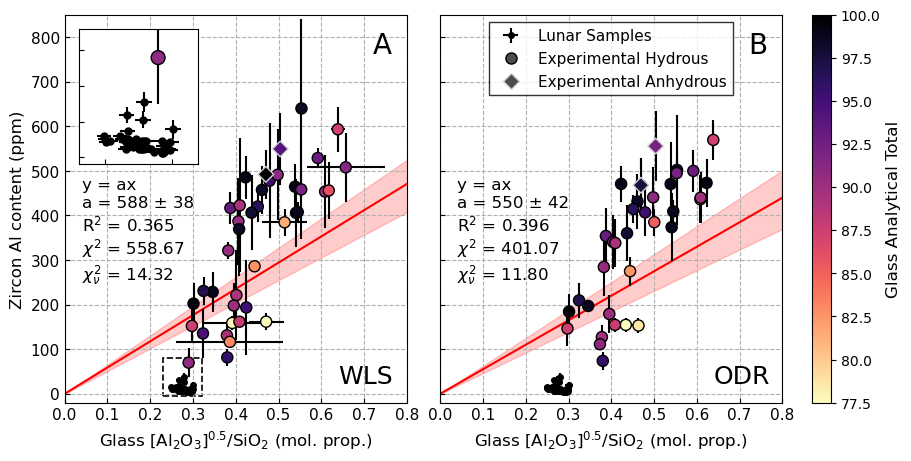

In [100]:
# Calibration Range Plot
fs, ms = 12, 8
x_fine = np.linspace(0, 1, 100)

total_pub = exp_data_ox.sum(axis=1)
total_filt = glass_filt[oxides].sum(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(9., 4.5), sharey=True)

for sublabel, method, ax in zip("AB", ["WLS", "ODR"], [ax1, ax2]):
    ax.tick_params(tickdir="in", labelsize=fs-1)
    ax.grid(linestyle="--", zorder=-5)
    ax.text(s=sublabel, x=0.9, y=0.9, transform=ax.transAxes, fontsize=fs+8)
    ax.text(s=method, x=0.8, y=0.05, transform=ax.transAxes, fontsize=fs+6)
    ax.set_xlim(0., 0.8)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.set_xlabel("Glass [Al$_\\mathrm{2}$O$_\\mathrm{3}$]$^{\\mathrm{0.5}}$/SiO$_\\mathrm{2}$ (mol. prop.)", fontsize=fs)

#### Plot Published Data ####
# Plot Fit
ax1.plot(x_fine, linear_origin(WLS_O["beta"], x_fine), 'r-')
ax1.fill_between(
    x=x_fine,
    y1=WLS_O_ci[2],
    y2=WLS_O_ci[3],
    color="r", alpha=0.2
    )

# Plot Hydrous Glasses
hydrous = ~exp_data["Experiment ID"].isin(["M281200 a-1", "M291250  a-1"])
ax1.errorbar(
    x=exp_data["AlI"][hydrous], y=exp_data["Al_zircon"][hydrous],
    xerr=exp_data["AlI_std"][hydrous], yerr=exp_data["Al_zircon_std"][hydrous],
    fmt="", linestyle="", label="Experimental", ecolor="k"
    )
ax1.scatter(
    x=exp_data["AlI"][hydrous], y=exp_data["Al_zircon"][hydrous],
    c=glass_pub_tot[hydrous], marker="o", cmap="magma_r", ec="k", s=ms**2, zorder=10, vmin=77.5, vmax=100.
    )

# Plot Anhydrous
anhydrous = exp_data["Experiment ID"].isin(["M281200 a-1", "M291250  a-1"])
ax1.errorbar(
    x=exp_data["AlI"][anhydrous], y=exp_data["Al_zircon"][anhydrous],
    xerr=exp_data["AlI_std"][anhydrous], yerr=exp_data["Al_zircon_std"][anhydrous],
    fmt="", linestyle="", label="Experimental", ecolor="k"
    )
ax1.scatter(
    x=exp_data["AlI"][anhydrous], y=exp_data["Al_zircon"][anhydrous],
    c=glass_pub_tot[anhydrous], marker="D", cmap="magma_r", ec="lightgray", s=ms**2, zorder=10, vmin=77.5, vmax=100.
    )

# Plot Lunar Data
ax1.errorbar(
    x=Zr_data["AlIglass"], y=Zr_data["Al-in-zircon ppm"],
    xerr=Zr_data["± 1σ.3"], yerr=Zr_data["± 1σ.1"],
    marker=".", linestyle="", mec="k", mfc="k", label="Lunar Samples", ms=ms, ecolor="k"
    )

WLS_O_stats = f"""y = ax
a = {WLS_O['beta'][0]:.0f} ± {WLS_O['beta_err'][0]:.0f}
R$^2$ = {WLS_O["R2_wls"]:.3f}
$\\chi^2$ = {WLS_O["chi2"]:.2f}
$\\chi^2_\\nu$ = {WLS_O["chi2_red"]:.2f}
"""

ax1.text(s=WLS_O_stats, x=0.05, y=0.58, transform=ax1.transAxes, fontsize=fs, va='top')

#### Plot Filtered Data ####
# Fit
ax2.plot(x_fine, linear_origin(ODR_filt_O['beta'], x_fine), 'r-')
ax2.fill_between(
    x=x_fine,
    y1=ODR_filt_O_ci[2],
    y2=ODR_filt_O_ci[3],
    color="r", alpha=0.2)

# Plot Hydrous Glasses
hydrous = ~Repeats.index.isin(["M281200 a-1", "M291250  a-1"])
ax2.errorbar(
    x=Repeats["AlI mean"][hydrous], xerr=Repeats["AlI std_wt"][hydrous],
    y=Repeats["Al27 ppm mean"][hydrous], yerr=Repeats["Al27 ppm std_wt"][hydrous],
    marker="", linestyle="", ecolor="k"
    )
c = ax2.scatter(
    x=Repeats["AlI mean"][hydrous], y=Repeats["Al27 ppm mean"][hydrous],
    c=glass_filt_tot[hydrous], cmap="magma_r", ec="k", s=ms**2, zorder=10,  vmin=77.5, vmax=100.,
    )

# Plot Anhydrous
anhydrous = Repeats.index.isin(["M281200 a-1", "M291250 a-1"])
ax2.errorbar(
    x=Repeats["AlI mean"][anhydrous], xerr=Repeats["AlI std_wt"][anhydrous],
    y=Repeats["Al27 ppm mean"][anhydrous], yerr=Repeats["Al27 ppm std_wt"][anhydrous],
    marker="", linestyle="", ecolor="k"
    )
c = ax2.scatter(
    x=Repeats["AlI mean"][anhydrous], y=Repeats["Al27 ppm mean"][anhydrous],
    c=glass_filt_tot[anhydrous], marker="D", cmap="magma_r", ec="lightgray", s=ms**2, zorder=10,  vmin=77.5, vmax=100.,
    )

# Lunar Data
ax2.errorbar(
    x=Zr_data["AlIglass"], y=Zr_data["Al-in-zircon ppm"],
    xerr=np.sqrt(2)*Zr_data["± 1σ.3"], yerr=Zr_data["± 1σ.1"],
    marker=".", linestyle="", mec="k", mfc="k", label="Lunar Samples", ms=ms, ecolor="k"
    )


ODR_O_stats = f"""y = ax
a = {ODR_filt_O['beta'][0]:.0f} ± {ODR_filt_O['beta_err'][0]:.0f}
R$^2$ = {ODR_filt_O["R2_w"]:.3f}
$\\chi^2$ = {ODR_filt_O["chi2"]:.2f}
$\\chi^2_\\nu$ = {ODR_filt_O["chi2_red"]:.2f}
"""

ax2.text(s=ODR_O_stats, x=0.05, y=0.58, transform=ax2.transAxes, fontsize=fs, va='top')

ax2.errorbar([], [], marker="o", linestyle="", mec="k", mfc=[0.3, 0.3, 0.3], ms=ms, ecolor="k", label="Experimental Hydrous")
ax2.errorbar([], [], marker="D", linestyle="", mec="lightgray", mfc=[0.3, 0.3, 0.3], ms=ms, ecolor="k", label="Experimental Anhydrous")

cbar = plt.colorbar(c, ax=ax2)
cbar.set_label(label='Glass Analytical Total', fontsize=fs)

ax1.set_ylim(-20, 850)
ax1.set_ylabel("Zircon Al content (ppm)", fontsize=fs)
ax2.legend(edgecolor="k", fancybox=False, loc="upper center", fontsize=fs-1)


# Inset Axes
axins = inset_axes(ax1, width="35%", height="35%", loc="upper left", borderpad=1)

axins.errorbar(
    x=Zr_data["AlIglass"], y=Zr_data["Al-in-zircon ppm"],
    xerr=Zr_data["± 1σ.3"], yerr=Zr_data["± 1σ.1"],
    marker=".", linestyle="", color="k", ecolor="k", ms=ms+2
    )
axins.errorbar(
    x=exp_data["AlI"], y=exp_data["Al_zircon"],
    xerr=exp_data["AlI_std"], yerr=exp_data["Al_zircon_std"],
    marker="", linestyle="", ecolor="k", ms=ms+2
    )
axins.scatter(
    x=exp_data["AlI"], y=exp_data["Al_zircon"],
    c=glass_pub_tot, cmap="magma_r", ec="k", s=(ms+2)**2, zorder=10, vmin=77.5, vmax=100.
    )

rect = patches.Rectangle(
    (0.23, -5), 0.32 - 0.23, 90 -5,
    linewidth=1.2, edgecolor='k', linestyle="--", facecolor='white', zorder=1
    )
ax1.add_patch(rect)

# Zoom in to lunar region
axins.set_xlim(0.23, 0.32)
axins.set_ylim(-5, 90)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(tickdir="in")

plt.savefig('Experimental_Old_New.png', dpi=300)
plt.show()

In [88]:
# Propagate Lunar Data Through Model

ODR_O_propagated = tellinghuisen_two_step(
    x_cal=Repeats["AlI mean"].values,
    y_cal=Repeats["Al27 ppm mean"].values,
    sx=Repeats["AlI std_wt"].values,
    sy=Repeats["Al27 ppm std_wt"].values,
    y_unknown=Zr_data["Al-in-zircon ppm"].values,
    sy_unknown=Zr_data["± 1σ.1"].values,
    model_func=linear_origin,
    beta0=[550.]
)

ODR_I_propagated = tellinghuisen_two_step(
    x_cal=Repeats["AlI mean"].values,
    y_cal=Repeats["Al27 ppm mean"].values,
    sx=Repeats["AlI std_wt"].values,
    sy=Repeats["Al27 ppm std_wt"].values,
    y_unknown=Zr_data["Al-in-zircon ppm"].values,
    sy_unknown=Zr_data["± 1σ.1"].values,
    model_func=linear_intercept,
    beta0=[1433., -369.]
)


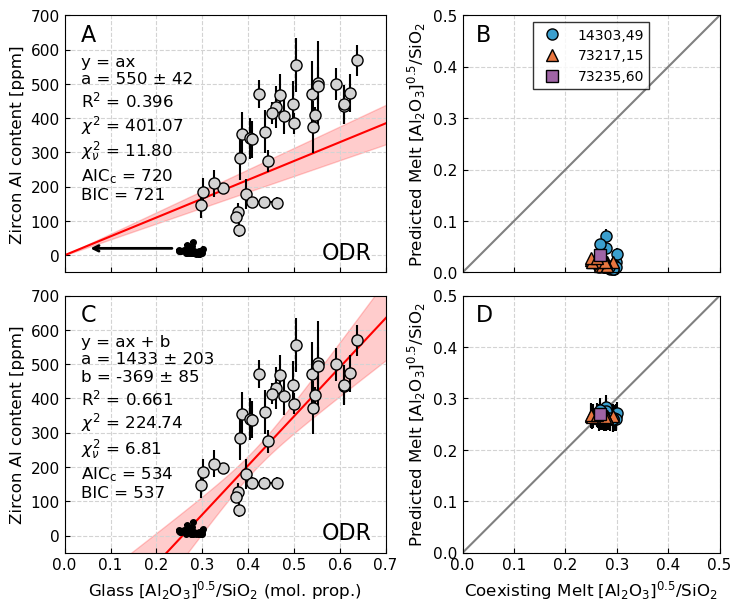

In [89]:
fs, ms = 12, 8

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True, figsize=(7.5, 6), sharex="col", sharey="col")

## Regression Plots ##
for ax in [ax1, ax3]:
    ax.errorbar(
        x=Zr_data["AlIglass"], y=Zr_data["Al-in-zircon ppm"],
        xerr=Zr_data["± 1σ.3"], yerr=Zr_data["± 1σ.1"],
        marker=".", linestyle="", mec="k", mfc="k", label="Lunar Samples", ms=ms, ecolor="k",
        zorder=5
        )
    ax.errorbar(
        x=Repeats["AlI mean"], xerr=Repeats["AlI std_wt"],
        y=Repeats["Al27 ppm mean"], yerr=Repeats["Al27 ppm std_wt"],
        marker="o", mec="k", mfc='lightgray', linestyle="", ecolor="k", ms=ms,
        zorder=5
        )

# Filtered Origin
ax1.plot(x_fine, linear_origin(ODR_filt_O["beta"], x_fine), 'r-')
ax1.fill_between(
    x=x_fine,
    y1=ODR_filt_O_ci[2],
    y2=ODR_filt_O_ci[3],
    color="r", alpha=0.2)

# Filtered Intercept
ax3.plot(x_fine, linear_intercept(ODR_filt_I["beta"], x_fine), 'r-')
ax3.fill_between(
    x=x_fine,
    y1=ODR_filt_I_ci[2],
    y2=ODR_filt_I_ci[3],
    color="r", alpha=0.2)

for ax in (ax1, ax3):
    ax.set_ylabel("Zircon Al content [ppm]", fontsize=fs)
    ax.grid(color="lightgray", linestyle="--")
    ax.tick_params(labelsize=fs-1, tickdir="in")
    ax.text(s="ODR", x=0.8, y=0.05, transform=ax.transAxes, fontsize=fs+4)

ax1.set_ylim(-50, 700)
ax1.set_xlim(0.0, 0.7)

ax1.annotate(
    '', xy=(0.05, 20), xytext=(0.24, 20),
    arrowprops=dict(arrowstyle='->', color='k', lw=2)
)

# Plot Labels and Text
sub_label = ["A", "B", "C", "D"]
for label, ax in zip(sub_label, [ax1, ax2, ax3, ax4]):
    ax.text(s=label, x=0.05, y=0.90, transform=ax.transAxes, fontsize=fs+4)

ODR_O_stats = f"""y = ax
a = {ODR_filt_O['beta'][0]:.0f} ± {ODR_filt_O['beta_err'][0]:.0f}
R$^2$ = {ODR_filt_O["R2_w"]:.3f}
$\\chi^2$ = {ODR_filt_O["chi2"]:.2f}
$\\chi^2_\\nu$ = {ODR_filt_O["chi2_red"]:.2f}
AIC$_{{\\text{{c}}}}$ = {ODR_filt_O["AICc"]:.0f}
BIC = {ODR_filt_O["BIC"]:.0f}
"""

ax1.text(s=ODR_O_stats, x=0.05, y=0.85, transform=ax1.transAxes, fontsize=fs, va='top')

ODR_I_stats = f"""y = ax + b
a = {ODR_filt_I['beta'][0]:.0f} ± {ODR_filt_I['beta_err'][0]:.0f}
b = {ODR_filt_I['beta'][1]:.0f} ± {ODR_filt_I['beta_err'][1]:.0f}
R$^2$ = {ODR_filt_I["R2_w"]:.3f}
$\\chi^2$ = {ODR_filt_I["chi2"]:.2f}
$\\chi^2_\\nu$ = {ODR_filt_I["chi2_red"]:.2f}
AIC$_{{\\text{{c}}}}$ = {ODR_filt_I["AICc"]:.0f}
BIC = {ODR_filt_I["BIC"]:.0f}
"""

ax3.text(s=ODR_I_stats, x=0.05, y=0.85, transform=ax3.transAxes, fontsize=fs, va='top')

## Propagated Points ##
Samples = ['14303,49', '73217,15', '73235,60']
Colours = [(0.231, 0.624, 0.808), (0.914, 0.463, 0.247), (0.624, 0.392, 0.647)]
Markers = ["o", "^", "s"]

for ax in (ax2, ax4):
    ax.plot([0, 0.5], [0, 0.5], linestyle='-', color="gray")
    ax.set_ylabel("Predicted Melt [Al$_\\mathrm{2}$O$_\\mathrm{3}$]$^{\\mathrm{0.5}}$/SiO$_\\mathrm{2}$", fontsize=fs)
    ax.tick_params(tickdir="in", labelsize=fs-1)
    ax.set_aspect('equal')
    ax.grid(color="lightgray", linestyle="--")
    ax.set_xticks(np.arange(0., 0.6, 0.1))
    ax.set_yticks(np.arange(0., 0.6, 0.1))

for i, sample in enumerate(Samples):
    Filter = Zr_data["Sample"] == sample
    ax2.errorbar(
        x=Zr_data["AlIglass"][Filter], y=ODR_O_propagated['x_u'][Filter],
        xerr=Zr_data["± 1σ.2"][Filter], yerr=ODR_O_propagated['x_u_err'][Filter],
        marker=Markers[i], markerfacecolor=Colours[i],
        linestyle="", markeredgecolor="k", markersize=8, ecolor="k", clip_on=False
        )
    ax4.errorbar(
        x=Zr_data["AlIglass"][Filter], y=ODR_I_propagated['x_u'][Filter],
        xerr=Zr_data["± 1σ.2"][Filter], yerr=ODR_I_propagated['x_u_err'][Filter],
        marker=Markers[i], markerfacecolor=Colours[i],
        linestyle="", markeredgecolor="k", markersize=8, ecolor="k"
        )

    ax2.plot([], [], marker=Markers[i], markerfacecolor=Colours[i], linestyle="", markeredgecolor="k", markersize=8, zorder=5, label=sample)

ax3.set_xlabel("Glass [Al$_\\mathrm{2}$O$_\\mathrm{3}$]$^{\\mathrm{0.5}}$/SiO$_\\mathrm{2}$ (mol. prop.)", fontsize=fs)
ax4.set_xlabel("Coexisting Melt [Al$_\\mathrm{2}$O$_\\mathrm{3}$]$^{\\mathrm{0.5}}$/SiO$_\\mathrm{2}$", fontsize=fs)

ax2.legend(edgecolor="k", fancybox=False, loc="upper center")
ax2.set_xlim(0.0, 0.5)
ax2.set_ylim(0.0, 0.5)

plt.savefig("Compare_Experiment_Fits.png", dpi=300)
plt.show()